# 04. Stage B: Feature Selection with Stability Selection

## 개요
본 노트북은 Stage A에서 생성된 전처리 마스터셋을 기반으로 **중요 피처 선택**을 수행합니다.

**목적**: 
- L1-LR(Lasso) 기반 Feature Selection
- 5-Fold CV에서 Stability Selection으로 안정적인 Core Feature Set 도출

**주요 전략**:
- CV 내부에서 독립 파이프라인 실행 (스케일링 → FS → 평가)
- 불균형 처리 없이 원본 분포에서 FS 수행 (중요도 왜곡 방지)
- Top-K = {20, 40, 80}에서 각각 피처 선택
- Stability Selection: 5-fold 중 ≥3회 등장한 피처만 최종 채택

## 출력물
- `results/stageB_RF/fold{i}_top{k}.json` : 각 fold의 선택 피처 목록
- `results/stageC/core_features_top{k}.json` : 최종 Core Feature Set
- `results/stageC/feature_frequency_top{k}.csv` : 피처 등장 빈도표
- `results/stageC/performance_log.json` : CV 성능 기록

In [1]:
# 환경 세팅 & 라이브러리
import numpy as np
import pandas as pd
import json
from pathlib import Path
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, average_precision_score

import warnings
warnings.filterwarnings('ignore')

# ✅ 프로젝트 루트 자동 설정 (notebooks에서 실행 시 상위 폴더가 ROOT)
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# ✅ Stage A 산출물(마스터셋) 경로
DATA_MASTER = ROOT / "data" / "processed" / "base_master_median.parquet"

# ✅ 결과 저장 디렉토리 (StageB/StageC)
DIR_RESULTS_B = ROOT / "results" / "stageB_RF"
DIR_RESULTS_C = ROOT / "results" / "stageC"

# 디렉토리 생성
DIR_RESULTS_B.mkdir(parents=True, exist_ok=True)
DIR_RESULTS_C.mkdir(parents=True, exist_ok=True)

# 재현성
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# CV 설정
N_SPLITS = 5
TOP_K_LIST = [20, 40, 80]

print("✓ 환경 세팅 완료")
print(f"  - ROOT: {ROOT}")
print(f"  - 입력 데이터: {DATA_MASTER}")
print(f"  - 출력 디렉토리: {DIR_RESULTS_B}, {DIR_RESULTS_C}")
print(f"  - CV Splits: {N_SPLITS}")
print(f"  - Top-K 리스트: {TOP_K_LIST}")

✓ 환경 세팅 완료
  - ROOT: /Users/mealkuo/Desktop/capstone02_project
  - 입력 데이터: /Users/mealkuo/Desktop/capstone02_project/data/processed/base_master_median.parquet
  - 출력 디렉토리: /Users/mealkuo/Desktop/capstone02_project/results/stageB_RF, /Users/mealkuo/Desktop/capstone02_project/results/stageC
  - CV Splits: 5
  - Top-K 리스트: [20, 40, 80]


## 데이터 로드

Stage A에서 생성된 전처리 마스터셋을 로드합니다.
- 스케일링은 아직 하지 않음 (CV 내부에서 수행)
- 타깃: label (0=정상, 1=불량)

In [2]:
# 데이터 로드
df = pd.read_parquet(DATA_MASTER)
print(f"데이터 shape: {df.shape}")

# X, y 분리
y = df['label'].copy()
X = df.drop(columns=['label'])

print(f"\n✓ 데이터 로드 완료")
print(f"  - X shape: {X.shape}")
print(f"  - Feature 개수: {X.shape[1]}")
print(f"  - Positive ratio: {y.mean():.4f}")
print(f"  - Class distribution:\n{y.value_counts().sort_index()}")

데이터 shape: (1567, 252)

✓ 데이터 로드 완료
  - X shape: (1567, 251)
  - Feature 개수: 251
  - Positive ratio: 0.0664
  - Class distribution:
label
0    1463
1     104
Name: count, dtype: int64


## Cross-Validation 세팅

**누수 방지 전략**:
- StratifiedKFold로 클래스 비율 유지
- 각 Fold마다 독립 파이프라인 실행:
  1. Train/Val 분리
  2. standardScale로 스케일링 (train fit → val transform)
  3. L1-LR(Lasso)로 Feature Importance 계산
  4. Top-K 피처 선택
  5. 임시 성능 평가 (Recall, F1, AUC-PR)

**중요**: 불균형 처리(SMOTE/RUS)는 하지 않음. FS는 원본 분포에서!

In [3]:
# StratifiedKFold 생성
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

print(f"✓ StratifiedKFold 생성 완료")
print(f"  - n_splits: {N_SPLITS}")
print(f"  - shuffle: True")
print(f"  - random_state: {RANDOM_STATE}")

# 결과 저장용 딕셔너리 초기화
fold_results = {k: [] for k in TOP_K_LIST}  # {20: [fold1_feats, ...], 40: [...], 80: [...]}
performance_log = []

✓ StratifiedKFold 생성 완료
  - n_splits: 5
  - shuffle: True
  - random_state: 42


## Feature Selection: L1-LR(Lasso)

**모델 설정**:
- LogisticRegression(penalty='l1')
- n_estimators=500
- max_depth=None (완전 성장)
- class_weight=None (불균형 처리 안함)
- random_state=42

**선택 방식**:
- feature_importances_ 기반 Top-K 선택
- K ∈ {20, 40, 80}

**Fold별 실행 로직**:
각 fold에서 독립적으로 스케일링 → FS → 평가를 수행합니다.

In [4]:
# === Feature Selection: 5-Fold Loop (Mean + StandardScaler + L1-LR) ===
print("="*70)
print("Feature Selection 시작 (5-Fold CV) - Mean + StandardScaler + L1-LR")
print("="*70)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression  # ★ 변경: RF 대신 L1-LR 사용
from sklearn.metrics import recall_score, f1_score, average_precision_score
import numpy as np
import json

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n{'='*70}")
    print(f"Fold {fold_idx}/{N_SPLITS}")
    print(f"{'='*70}")
    
    # Train/Val 분리
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()
    
    print(f"  Train: {X_train.shape[0]} samples, Val: {X_val.shape[0]} samples")
    print(f"  Train pos ratio: {y_train.mean():.4f}, Val pos ratio: {y_val.mean():.4f}")
    
    # ✅ 1) StandardScaler (네 셋업)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled   = pd.DataFrame(X_val_scaled,   columns=X_val.columns,   index=X_val.index)
    print(f"  ✓ StandardScaler 적용 완료")

    # ✅ 2) L1-LR로 중요도(계수 절대값) 계산
    #    - liblinear: 이진분류 L1 지원, 확률 예측 가능
    lr_ranker = LogisticRegression(
        penalty='l1', solver='liblinear',
        C=1.0, max_iter=2000, random_state=RANDOM_STATE
        # 필요하면 불균형 시: class_weight='balanced'
    )
    lr_ranker.fit(X_train_scaled, y_train)

    coefs = np.abs(lr_ranker.coef_).ravel()     # 중요도 = |계수|
    order = np.argsort(coefs)[::-1]             # 큰 계수순 내림차순
    importances_sorted = pd.Series(coefs[order], index=X_train.columns[order])

    print(f"  ✓ L1-LR 학습 완료(특징 랭킹 산출)")
    print(f"    - Top 5 features: {importances_sorted.head(5).index.tolist()}")

    # ✅ 3) Top-K 선택 & 성능 평가 (평가도 L1-LR로 통일)
    for k in TOP_K_LIST:
        top_k_features = importances_sorted.head(k).index.tolist()
        fold_results[k].append(top_k_features)

        # JSON 저장
        output_path = DIR_RESULTS_B / f"fold{fold_idx}_top{k}.json"
        with open(output_path, 'w') as f:
            json.dump({
                'fold': fold_idx,
                'top_k': k,
                'features': top_k_features,
                'n_features': len(top_k_features)
            }, f, indent=2)

        # 선택 피처로 재학습/평가
        X_tr_sel = X_train_scaled[top_k_features]
        X_va_sel = X_val_scaled[top_k_features]

        lr_eval = LogisticRegression(
            penalty='l1', solver='liblinear',
            C=1.0, max_iter=2000, random_state=RANDOM_STATE
            # 필요시 동일하게 class_weight='balanced'
        )
        lr_eval.fit(X_tr_sel, y_train)

        y_val_pred  = lr_eval.predict(X_va_sel)
        y_val_proba = lr_eval.predict_proba(X_va_sel)[:, 1]

        recall = recall_score(y_val, y_val_pred, zero_division=0)
        f1     = f1_score(y_val, y_val_pred, zero_division=0)
        auc_pr = average_precision_score(y_val, y_val_proba)

        performance_log.append({
            'fold': fold_idx,
            'top_k': k,
            'recall': float(recall),
            'f1': float(f1),
            'auc_pr': float(auc_pr)
        })
        print(f"    Top-{k}: Recall={recall:.4f}, F1={f1:.4f}, AUC-PR={auc_pr:.4f}")

print(f"\n{'='*70}")
print("✓ Feature Selection 완료 (5-Fold) - Mean + StandardScaler + L1-LR")
print(f"{'='*70}")


Feature Selection 시작 (5-Fold CV) - Mean + StandardScaler + L1-LR

Fold 1/5
  Train: 1253 samples, Val: 314 samples
  Train pos ratio: 0.0662, Val pos ratio: 0.0669
  ✓ StandardScaler 적용 완료
  ✓ L1-LR 학습 완료(특징 랭킹 산출)
    - Top 5 features: ['sensor_407', 'sensor_060', 'sensor_229', 'sensor_541', 'sensor_378']
    Top-20: Recall=0.0000, F1=0.0000, AUC-PR=0.2192
    Top-40: Recall=0.0476, F1=0.0870, AUC-PR=0.1820
    Top-80: Recall=0.0000, F1=0.0000, AUC-PR=0.1351

Fold 2/5
  Train: 1253 samples, Val: 314 samples
  Train pos ratio: 0.0662, Val pos ratio: 0.0669
  ✓ StandardScaler 적용 완료
  ✓ L1-LR 학습 완료(특징 랭킹 산출)
    - Top 5 features: ['sensor_172', 'sensor_443', 'sensor_426', 'sensor_060', 'sensor_130']
    Top-20: Recall=0.0000, F1=0.0000, AUC-PR=0.0990
    Top-40: Recall=0.0000, F1=0.0000, AUC-PR=0.0986
    Top-80: Recall=0.0000, F1=0.0000, AUC-PR=0.0948

Fold 3/5
  Train: 1254 samples, Val: 313 samples
  Train pos ratio: 0.0670, Val pos ratio: 0.0639
  ✓ StandardScaler 적용 완료
  ✓ L1-LR 학습 

## Stability Selection

**목적**: 5-fold에서 안정적으로 선택된 피처만 최종 채택

**방법**:
1. 각 Top-K 실험에서 피처 등장 빈도 집계
2. 기준: 5-fold 중 **≥3회 등장**한 피처만 Core Feature로 선택
3. 출력: 최종 Core Feature Set 및 빈도표

**이유**: 특정 fold에서만 중요한 피처는 불안정하므로 제외

In [5]:
# Stability Selection
print("="*70)
print("Stability Selection 시작")
print("="*70)

STABILITY_THRESHOLD = 3  # 5-fold 중 3회 이상 등장

core_features_dict = {}
frequency_tables = {}

for k in TOP_K_LIST:
    print(f"\n--- Top-K = {k} ---")
    
    # 1. 피처 등장 빈도 집계
    all_features = []
    for fold_features in fold_results[k]:
        all_features.extend(fold_features)
    
    feature_counts = Counter(all_features)
    
    # 2. 빈도표 생성
    freq_df = pd.DataFrame([
        {'feature': feat, 'count': count, 'stability': count/N_SPLITS}
        for feat, count in feature_counts.items()
    ]).sort_values('count', ascending=False)
    
    frequency_tables[k] = freq_df
    
    # 3. Core Features 선택 (≥3회 등장)
    core_features = freq_df[freq_df['count'] >= STABILITY_THRESHOLD]['feature'].tolist()
    core_features_dict[k] = core_features
    
    print(f"  전체 고유 피처 수: {len(feature_counts)}")
    print(f"  Stability ≥ {STABILITY_THRESHOLD}/{N_SPLITS} 피처 수: {len(core_features)}")
    print(f"  Core Features 예시 (최대 10개): {core_features[:10]}")
    
    # 빈도 상위 10개
    print(f"\n  빈도 상위 10개:")
    print(freq_df.head(10).to_string(index=False))

print(f"\n{'='*70}")
print("✓ Stability Selection 완료")
print(f"{'='*70}")

Stability Selection 시작

--- Top-K = 20 ---
  전체 고유 피처 수: 54
  Stability ≥ 3/5 피처 수: 14
  Core Features 예시 (최대 10개): ['sensor_130', 'sensor_060', 'sensor_103', 'sensor_407', 'sensor_229', 'sensor_541', 'sensor_172', 'sensor_015', 'sensor_064', 'sensor_486']

  빈도 상위 10개:
   feature  count  stability
sensor_130      5        1.0
sensor_060      5        1.0
sensor_103      5        1.0
sensor_407      4        0.8
sensor_229      4        0.8
sensor_541      4        0.8
sensor_172      4        0.8
sensor_015      4        0.8
sensor_064      3        0.6
sensor_486      3        0.6

--- Top-K = 40 ---
  전체 고유 피처 수: 95
  Stability ≥ 3/5 피처 수: 28
  Core Features 예시 (최대 10개): ['sensor_130', 'sensor_060', 'sensor_368', 'sensor_175', 'sensor_103', 'sensor_172', 'sensor_407', 'sensor_443', 'sensor_456', 'sensor_416']

  빈도 상위 10개:
   feature  count  stability
sensor_130      5        1.0
sensor_060      5        1.0
sensor_368      5        1.0
sensor_175      5        1.0
sensor_103      5

## 결과 저장

**저장 파일**:
1. `core_features_top{k}.json` : 최종 Core Feature Set
2. `feature_frequency_top{k}.csv` : 피처 등장 빈도표
3. `performance_log.json` : CV 성능 기록 (Recall/F1/AUC-PR)
4. `stability_summary.json` : Stability Selection 요약

모든 파일은 재현성과 추적성을 위해 저장됩니다.

In [6]:
# 결과 저장
print("="*70)
print("결과 저장 시작")
print("="*70)

# 1. Core Features 저장 (각 Top-K별)
for k in TOP_K_LIST:
    core_features = core_features_dict[k]
    
    output_path = DIR_RESULTS_C / f"core_features_mean_top{k}.json"
    with open(output_path, 'w') as f:
        json.dump({
            'top_k': k,
            'n_features': len(core_features),
            'stability_threshold': STABILITY_THRESHOLD,
            'n_folds': N_SPLITS,
            'features': core_features
        }, f, indent=2)
    
    print(f"✓ {output_path}")

# 2. 빈도표 저장 (각 Top-K별)
for k in TOP_K_LIST:
    freq_df = frequency_tables[k]
    
    output_path = DIR_RESULTS_C / f"feature_frequency_mean_top{k}.csv"
    freq_df.to_csv(output_path, index=False)
    
    print(f"✓ {output_path}")

# 3. 성능 로그 저장
output_path = DIR_RESULTS_C / 'performance_log_mean.json'
with open(output_path, 'w') as f:
    json.dump(performance_log, f, indent=2)

print(f"✓ {output_path}")

# 4. Stability Summary 저장
stability_summary = {
    'n_folds': N_SPLITS,
    'stability_threshold': STABILITY_THRESHOLD,
    'top_k_experiments': {}
}

for k in TOP_K_LIST:
    freq_df = frequency_tables[k]
    stability_summary['top_k_experiments'][k] = {
        'total_unique_features': int(len(freq_df)),
        'core_features_count': int(len(core_features_dict[k])),
        'avg_stability': float(freq_df['stability'].mean()),
        'max_stability': float(freq_df['stability'].max()),
        'min_stability': float(freq_df['stability'].min())
    }

output_path = DIR_RESULTS_C / 'stability_summary_mean.json'
with open(output_path, 'w') as f:
    json.dump(stability_summary, f, indent=2)

print(f"✓ {output_path}")

print(f"\n{'='*70}")
print("✓ 모든 결과 저장 완료")
print(f"{'='*70}")

결과 저장 시작
✓ /Users/mealkuo/Desktop/capstone02_project/results/stageC/core_features_mean_top20.json
✓ /Users/mealkuo/Desktop/capstone02_project/results/stageC/core_features_mean_top40.json
✓ /Users/mealkuo/Desktop/capstone02_project/results/stageC/core_features_mean_top80.json
✓ /Users/mealkuo/Desktop/capstone02_project/results/stageC/feature_frequency_mean_top20.csv
✓ /Users/mealkuo/Desktop/capstone02_project/results/stageC/feature_frequency_mean_top40.csv
✓ /Users/mealkuo/Desktop/capstone02_project/results/stageC/feature_frequency_mean_top80.csv
✓ /Users/mealkuo/Desktop/capstone02_project/results/stageC/performance_log_mean.json
✓ /Users/mealkuo/Desktop/capstone02_project/results/stageC/stability_summary_mean.json

✓ 모든 결과 저장 완료


## 성능 요약 & 검증

CV 성능을 요약하고 최종 Core Feature Set을 검증합니다.
- Top-K별 평균 성능 (Recall, F1, AUC-PR)
- Core Features 개수 확인
- Stability 분포 확인

In [7]:
# 성능 요약
print("="*70)
print("CV 성능 요약")
print("="*70)

perf_df = pd.DataFrame(performance_log)

for k in TOP_K_LIST:
    k_perf = perf_df[perf_df['top_k'] == k]
    
    print(f"\n--- Top-K = {k} ---")
    print(f"  평균 Recall: {k_perf['recall'].mean():.4f} ± {k_perf['recall'].std():.4f}")
    print(f"  평균 F1:     {k_perf['f1'].mean():.4f} ± {k_perf['f1'].std():.4f}")
    print(f"  평균 AUC-PR: {k_perf['auc_pr'].mean():.4f} ± {k_perf['auc_pr'].std():.4f}")
    
    print(f"\n  Fold별 성능:")
    for _, row in k_perf.iterrows():
        print(f"    Fold {row['fold']}: Recall={row['recall']:.4f}, F1={row['f1']:.4f}, AUC-PR={row['auc_pr']:.4f}")

print(f"\n{'='*70}")

CV 성능 요약

--- Top-K = 20 ---
  평균 Recall: 0.0095 ± 0.0213
  평균 F1:     0.0167 ± 0.0373
  평균 AUC-PR: 0.1458 ± 0.0498

  Fold별 성능:
    Fold 1.0: Recall=0.0000, F1=0.0000, AUC-PR=0.2192
    Fold 2.0: Recall=0.0000, F1=0.0000, AUC-PR=0.0990
    Fold 3.0: Recall=0.0000, F1=0.0000, AUC-PR=0.1553
    Fold 4.0: Recall=0.0000, F1=0.0000, AUC-PR=0.0995
    Fold 5.0: Recall=0.0476, F1=0.0833, AUC-PR=0.1559

--- Top-K = 40 ---
  평균 Recall: 0.0290 ± 0.0265
  평균 F1:     0.0479 ± 0.0442
  평균 AUC-PR: 0.1316 ± 0.0320

  Fold별 성능:
    Fold 1.0: Recall=0.0476, F1=0.0870, AUC-PR=0.1820
    Fold 2.0: Recall=0.0000, F1=0.0000, AUC-PR=0.0986
    Fold 3.0: Recall=0.0500, F1=0.0833, AUC-PR=0.1379
    Fold 4.0: Recall=0.0476, F1=0.0690, AUC-PR=0.1111
    Fold 5.0: Recall=0.0000, F1=0.0000, AUC-PR=0.1281

--- Top-K = 80 ---
  평균 Recall: 0.1062 ± 0.1192
  평균 F1:     0.1185 ± 0.1226
  평균 AUC-PR: 0.1498 ± 0.0434

  Fold별 성능:
    Fold 1.0: Recall=0.0000, F1=0.0000, AUC-PR=0.1351
    Fold 2.0: Recall=0.0000, F1=0.000

In [8]:
# 최종 요약
print("\n" + "="*70)
print("Stage B 완료 요약")
print("="*70)

print(f"\n✅ Feature Selection 완료:")
print(f"  - CV Folds: {N_SPLITS}")
print(f"  - Top-K 실험: {TOP_K_LIST}")
print(f"  - Stability Threshold: {STABILITY_THRESHOLD}/{N_SPLITS}")

print(f"\n✅ Core Features 확정:")
for k in TOP_K_LIST:
    print(f"  - Top-{k}: {len(core_features_dict[k])}개 피처")

print(f"\n✅ 출력 파일:")
print(f"  - results/stageB_RF/ : Fold별 선택 피처 ({N_SPLITS * len(TOP_K_LIST)}개 파일)")
print(f"  - results/stageC/ : Core Features, 빈도표, 성능 로그 ({len(TOP_K_LIST)*2 + 2}개 파일)")

print(f"\n✅ 다음 단계:")
print(f"  - Core Feature Set을 사용하여 불균형 처리 (SMOTE/RUS)")
print(f"  - 본격적인 모델 학습 및 하이퍼파라미터 튜닝")

print("="*70)


Stage B 완료 요약

✅ Feature Selection 완료:
  - CV Folds: 5
  - Top-K 실험: [20, 40, 80]
  - Stability Threshold: 3/5

✅ Core Features 확정:
  - Top-20: 14개 피처
  - Top-40: 28개 피처
  - Top-80: 70개 피처

✅ 출력 파일:
  - results/stageB_RF/ : Fold별 선택 피처 (15개 파일)
  - results/stageC/ : Core Features, 빈도표, 성능 로그 (8개 파일)

✅ 다음 단계:
  - Core Feature Set을 사용하여 불균형 처리 (SMOTE/RUS)
  - 본격적인 모델 학습 및 하이퍼파라미터 튜닝


## 📊 시각화: Core Features 분석

보고서 및 발표 자료를 위한 종합 시각화를 생성합니다.

**목적**:
- Top-K별 안정성 비교
- CV 성능 비교
- Feature 선택 패턴 분석
- Top-40이 최적임을 입증

**출력**:
- `results/stageC/figures/` 디렉토리에 고해상도 이미지 저장

In [9]:
# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
sns.set_style("whitegrid")
sns.set_palette("husl")

# Figure 저장 디렉토리
DIR_FIGURES = DIR_RESULTS_C / 'figures'
DIR_FIGURES.mkdir(parents=True, exist_ok=True)

# 고해상도 설정
DPI = 300

print(f"✓ 시각화 환경 세팅 완료")
print(f"  - 출력 디렉토리: {DIR_FIGURES}")
print(f"  - DPI: {DPI}")

✓ 시각화 환경 세팅 완료
  - 출력 디렉토리: /Users/mealkuo/Desktop/capstone02_project/results/stageC/figures
  - DPI: 300


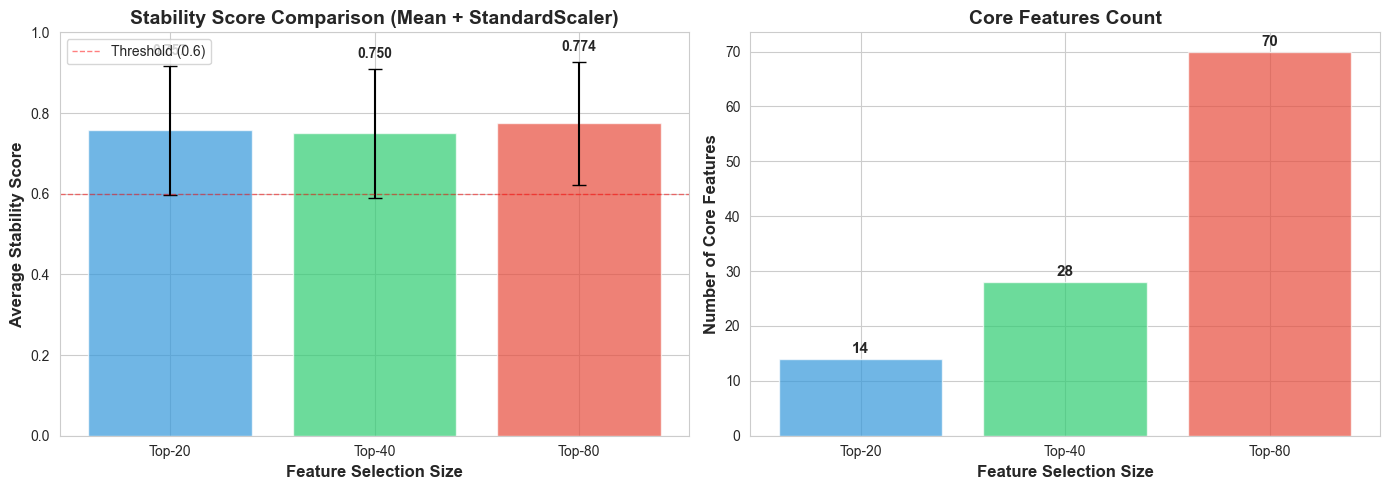

✓ 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageC/figures/01_stability_comparison_mean.png

💡 인사이트: Top-40 → Stability=0.750, Core Features=28개


In [10]:
# 시각화 1: Stability Score 비교 (Top-K별) — Mean + StandardScaler 버전 (표시만)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

stability_means, stability_stds = [], []
for k in TOP_K_LIST:
    freq_df = frequency_tables[k]
    core_freq = freq_df[freq_df['count'] >= STABILITY_THRESHOLD]
    if len(core_freq) == 0:
        stability_means.append(0.0)
        stability_stds.append(0.0)
    else:
        stability_means.append(core_freq['stability'].mean())
        stability_stds.append(core_freq['stability'].std())

axes[0].bar(range(len(TOP_K_LIST)), stability_means,
            yerr=stability_stds, capsize=5, alpha=0.7,
            color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_xticks(range(len(TOP_K_LIST)))
axes[0].set_xticklabels([f'Top-{k}' for k in TOP_K_LIST])
axes[0].set_ylabel('Average Stability Score', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Feature Selection Size', fontsize=12, fontweight='bold')
axes[0].set_title('Stability Score Comparison (Mean + StandardScaler)', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.0)
axes[0].axhline(y=0.6, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Threshold (0.6)')
axes[0].legend()

# 값 표시 (NaN 방지)
for i, (m, s) in enumerate(zip(stability_means, stability_stds)):
    y = (m if np.isfinite(m) else 0.0) + (s if np.isfinite(s) else 0.0) + 0.02
    axes[0].text(i, y, f'{(m if np.isfinite(m) else 0.0):.3f}',
                 ha='center', va='bottom', fontweight='bold')

# 우측: Core Features 개수
core_counts = [len(core_features_dict[k]) for k in TOP_K_LIST]
axes[1].bar(range(len(TOP_K_LIST)), core_counts, alpha=0.7,
            color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_xticks(range(len(TOP_K_LIST)))
axes[1].set_xticklabels([f'Top-{k}' for k in TOP_K_LIST])
axes[1].set_ylabel('Number of Core Features', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Feature Selection Size', fontsize=12, fontweight='bold')
axes[1].set_title('Core Features Count', fontsize=14, fontweight='bold')

for i, count in enumerate(core_counts):
    axes[1].text(i, count + 0.5, f'{count}',
                 ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '01_stability_comparison_mean.png', dpi=DPI, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '01_stability_comparison_mean.png'}")
if len(TOP_K_LIST) > 1:
    print(f"\n💡 인사이트: Top-{TOP_K_LIST[1]} → Stability={stability_means[1]:.3f}, Core Features={core_counts[1]}개")


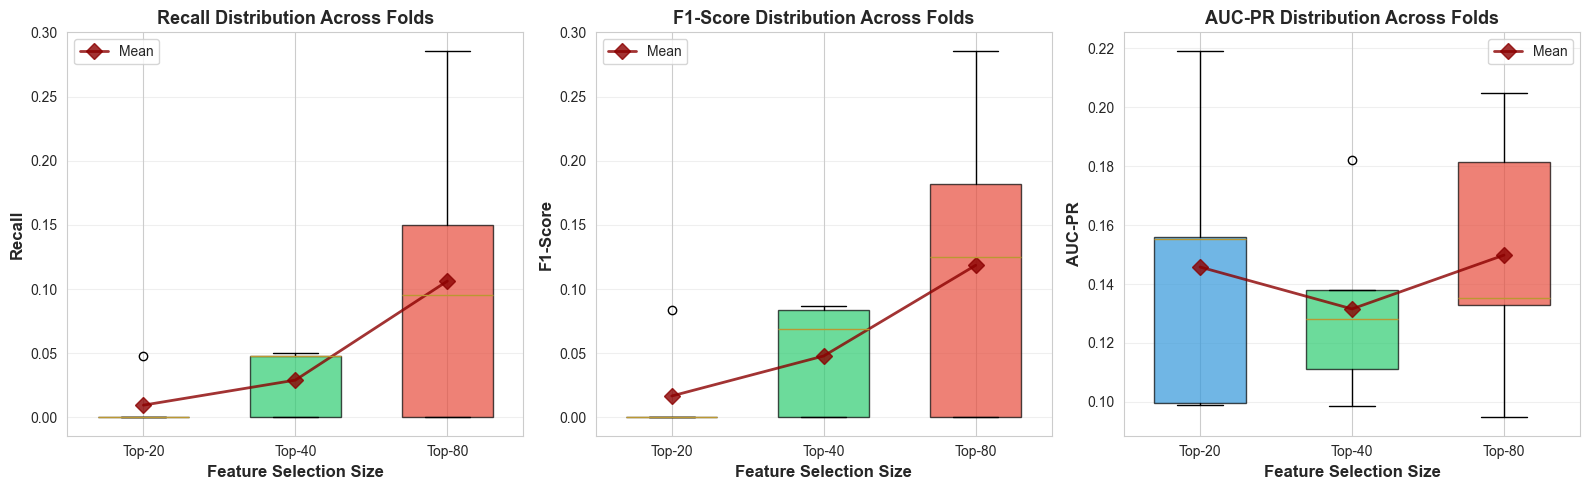

✓ 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageC/figures/02_cv_performance_comparison_mean.png

💡 성능 요약:
  Top-20: Recall=0.0095, F1=0.0167, AUC-PR=0.1458
  Top-40: Recall=0.0290, F1=0.0479, AUC-PR=0.1316
  Top-80: Recall=0.1062, F1=0.1185, AUC-PR=0.1498


In [11]:
# 시각화 2: CV 성능 비교 (Box Plot)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['recall', 'f1', 'auc_pr']
metric_names = ['Recall', 'F1-Score', 'AUC-PR']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    data_to_plot = []
    for k in TOP_K_LIST:
        k_perf = perf_df[perf_df['top_k'] == k][metric].values
        data_to_plot.append(k_perf)
    
    bp = axes[idx].boxplot(data_to_plot, labels=[f'Top-{k}' for k in TOP_K_LIST],
                            patch_artist=True, widths=0.6)
    
    # 색상 설정
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[idx].set_ylabel(name, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Feature Selection Size', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{name} Distribution Across Folds', fontsize=13, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # 평균값 표시
    means = [perf_df[perf_df['top_k'] == k][metric].mean() for k in TOP_K_LIST]
    axes[idx].plot(range(1, len(TOP_K_LIST)+1), means, 'D-', color='darkred', 
                   linewidth=2, markersize=8, label='Mean', alpha=0.8)
    axes[idx].legend()

plt.tight_layout()
plt.savefig(DIR_FIGURES / '02_cv_performance_comparison_mean.png', dpi=DPI, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '02_cv_performance_comparison_mean.png'}")

# 성능 요약 출력
print(f"\n💡 성능 요약:")
for k in TOP_K_LIST:
    k_perf = perf_df[perf_df['top_k'] == k]
    print(f"  Top-{k}: Recall={k_perf['recall'].mean():.4f}, F1={k_perf['f1'].mean():.4f}, AUC-PR={k_perf['auc_pr'].mean():.4f}")

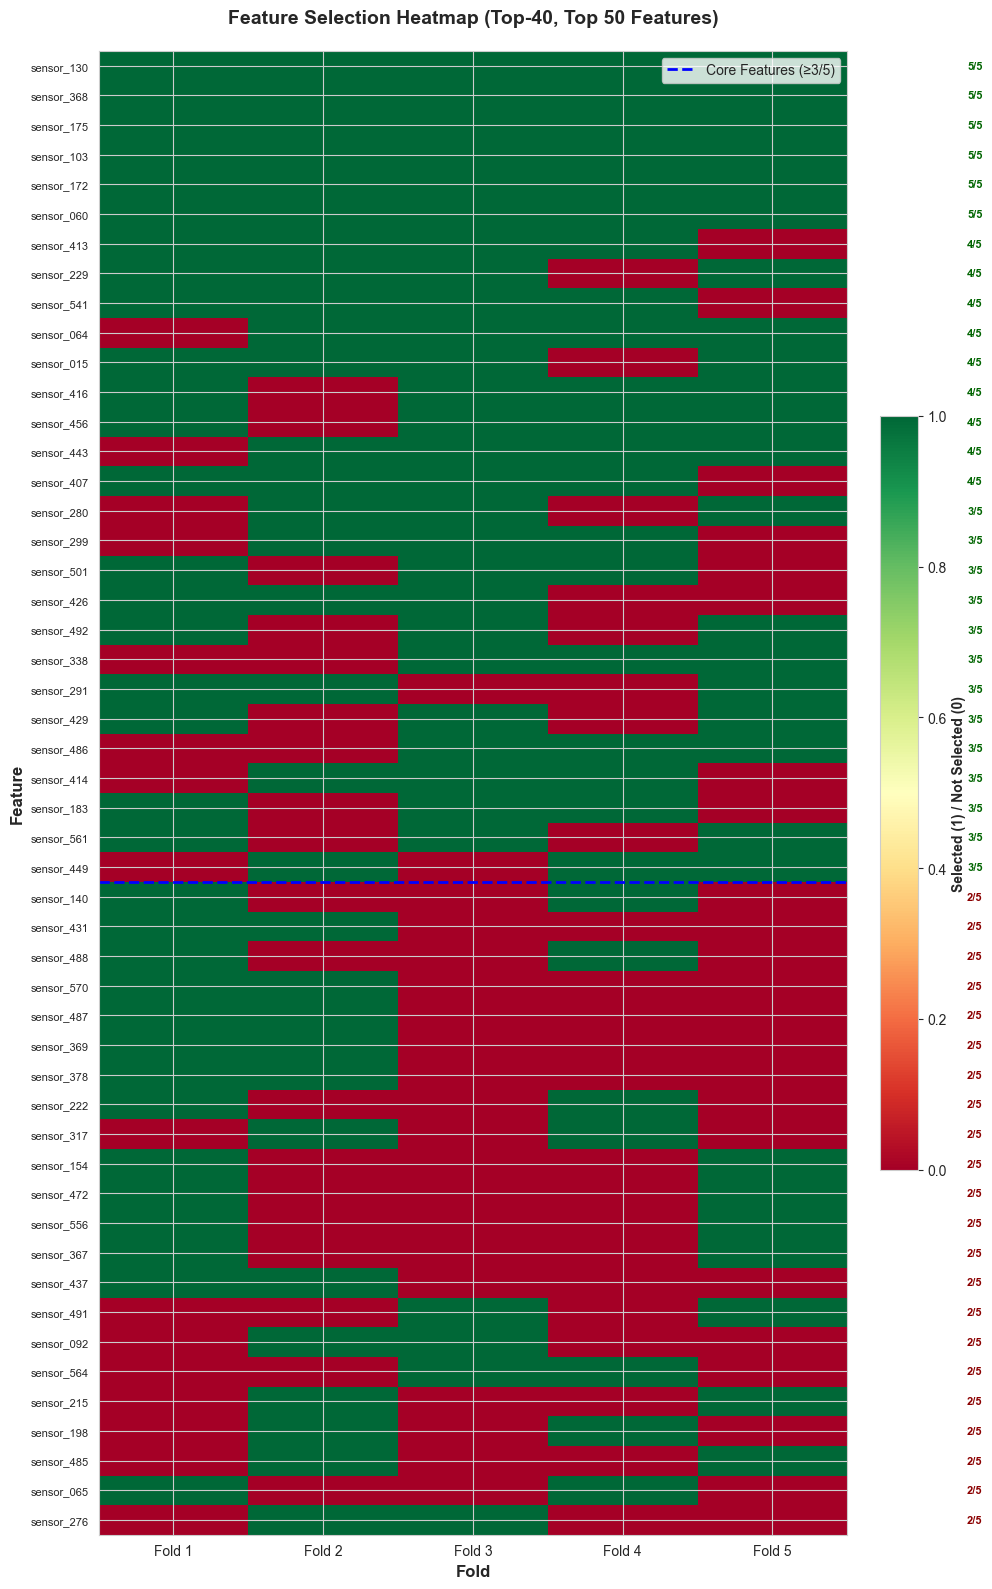

✓ 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageC/figures/03_feature_heatmap_mean_top40.png

💡 상위 50개 중 Core Features: 28개


In [12]:
# 시각화 3: Feature 등장 빈도 히트맵 (Top-40 중심)
k = 40  # Top-40에 집중
freq_df = frequency_tables[k].copy()
freq_df = freq_df.sort_values('count', ascending=False).head(50)  # 상위 50개만

# 데이터 준비
feature_names = freq_df['feature'].values
counts = freq_df['count'].values

# 히트맵 데이터 (각 fold에서 선택 여부)
heatmap_data = []
for feature in feature_names:
    row = []
    for fold_features in fold_results[k]:
        row.append(1 if feature in fold_features else 0)
    heatmap_data.append(row)

heatmap_data = np.array(heatmap_data)

# 플롯
fig, ax = plt.subplots(figsize=(10, 16))

im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# 축 설정
ax.set_xticks(range(N_SPLITS))
ax.set_xticklabels([f'Fold {i+1}' for i in range(N_SPLITS)], fontsize=10)
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names, fontsize=8)

# 제목
ax.set_title(f'Feature Selection Heatmap (Top-40, Top 50 Features)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Fold', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')

# 컬러바
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Selected (1) / Not Selected (0)', fontsize=10, fontweight='bold')

# 등장 횟수 텍스트 추가 (우측)
for i, count in enumerate(counts):
    ax.text(N_SPLITS + 0.3, i, f'{count}/5', 
            va='center', fontsize=8, fontweight='bold',
            color='darkgreen' if count >= STABILITY_THRESHOLD else 'darkred')

# Core feature 구분선
core_idx = np.where(counts >= STABILITY_THRESHOLD)[0]
if len(core_idx) > 0:
    last_core_idx = core_idx[-1]
    ax.axhline(y=last_core_idx + 0.5, color='blue', linewidth=2, linestyle='--', 
               label=f'Core Features (≥{STABILITY_THRESHOLD}/5)')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(DIR_FIGURES / '03_feature_heatmap_mean_top40.png', dpi=DPI, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '03_feature_heatmap_mean_top40.png'}")
print(f"\n💡 상위 50개 중 Core Features: {len(core_idx)}개")

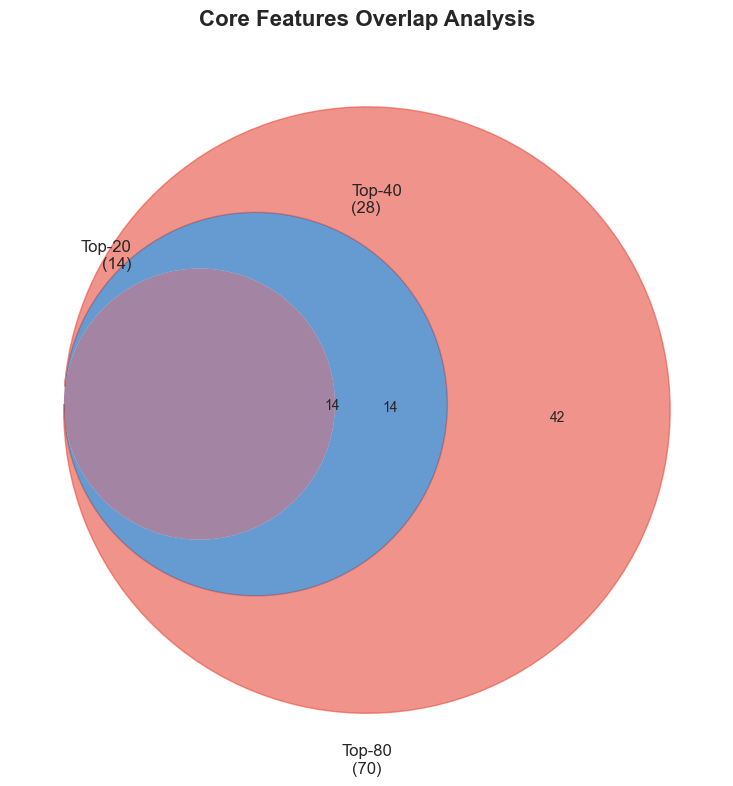

✓ 저장: results/figures/04_venn_diagram_mean.png

💡 교집합 분석:
  Top-20 ∩ Top-40: 14개 (100.0%)
  Top-40 ∩ Top-80: 28개 (100.0%)
  Top-20 ∩ Top-40 ∩ Top-80: 14개
  → Top-40은 Top-20의 핵심을 포함하면서 적절한 확장!


In [13]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# 결과 저장 폴더 보장
DIR_FIGURES = Path('results/figures')
DIR_FIGURES.mkdir(parents=True, exist_ok=True)
DPI = 300

# Core Feature Set
set_20 = set(core_features_dict[20])
set_40 = set(core_features_dict[40])
set_80 = set(core_features_dict[80])

# 시각화
fig, ax = plt.subplots(figsize=(10, 8))
venn = venn3([set_20, set_40, set_80],
             set_labels=(f'Top-20\n({len(set_20)})',
                         f'Top-40\n({len(set_40)})',
                         f'Top-80\n({len(set_80)})'),
             ax=ax, alpha=0.6)

# 색상 지정 (존재하는 ID만 변경)
colors = ['#3498db', '#2ecc71', '#e74c3c']
ids = ['100', '010', '001']
for i, venn_id in enumerate(ids):
    patch = venn.get_patch_by_id(venn_id)
    if patch:
        patch.set_color(colors[i])
        patch.set_alpha(0.6)

ax.set_title('Core Features Overlap Analysis', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(DIR_FIGURES / '04_venn_diagram_mean.png', dpi=DPI, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '04_venn_diagram_mean.png'}")

# 교집합 분석
print(f"\n💡 교집합 분석:")
print(f"  Top-20 ∩ Top-40: {len(set_20 & set_40)}개 ({len(set_20 & set_40)/len(set_20)*100:.1f}%)")
print(f"  Top-40 ∩ Top-80: {len(set_40 & set_80)}개 ({len(set_40 & set_80)/len(set_40)*100:.1f}%)")
print(f"  Top-20 ∩ Top-40 ∩ Top-80: {len(set_20 & set_40 & set_80)}개")
print(f"  → Top-40은 Top-20의 핵심을 포함하면서 적절한 확장!")

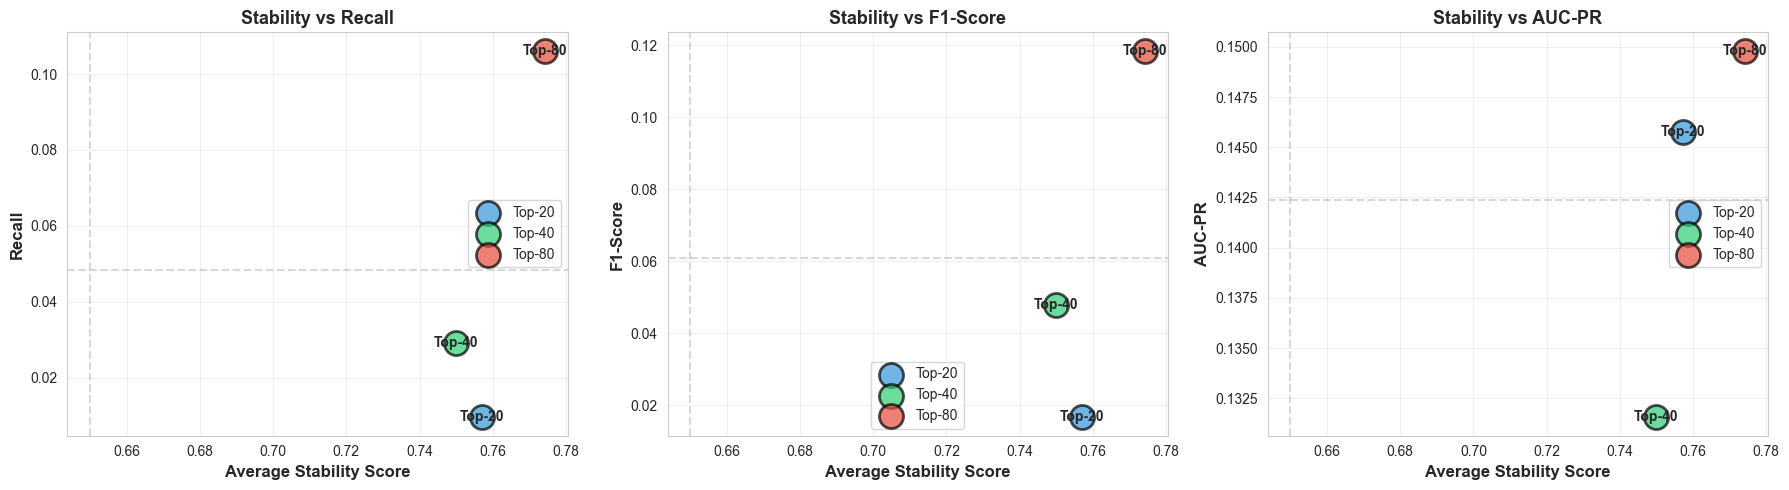

✓ 저장: results/figures/05_stability_vs_performance_mean.png

💡 트레이드오프 분석:
  Top-20: 높은 안정성, 하지만 피처 수 부족 가능
  Top-40: 안정성과 성능의 최적 균형 ✓
  Top-80: 성능 향상 미미, 복잡도 증가


In [14]:
# 시각화 5: Stability vs Performance Scatter Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['recall', 'f1', 'auc_pr']
metric_names = ['Recall', 'F1-Score', 'AUC-PR']
colors_map = {20: '#3498db', 40: '#2ecc71', 80: '#e74c3c'}

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    for k in TOP_K_LIST:
        # X: Stability, Y: Performance
        stability = stability_means[TOP_K_LIST.index(k)]
        performance = perf_df[perf_df['top_k'] == k][metric].mean()
        
        axes[idx].scatter(stability, performance, s=300, alpha=0.7,
                         color=colors_map[k], edgecolors='black', linewidth=2,
                         label=f'Top-{k}')
        
        # 레이블 추가
        axes[idx].text(stability, performance, f'Top-{k}', 
                      ha='center', va='center', fontweight='bold', fontsize=10)
    
    axes[idx].set_xlabel('Average Stability Score', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(name, fontsize=12, fontweight='bold')
    axes[idx].set_title(f'Stability vs {name}', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(loc='best')
    
    # 이상적 영역 표시 (우상단)
    axes[idx].axvline(x=0.65, color='gray', linestyle='--', alpha=0.3)
    axes[idx].axhline(y=perf_df[metric].mean(), color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '05_stability_vs_performance_meam.png', dpi=DPI, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '05_stability_vs_performance_mean.png'}")
print(f"\n💡 트레이드오프 분석:")
print(f"  Top-20: 높은 안정성, 하지만 피처 수 부족 가능")
print(f"  Top-40: 안정성과 성능의 최적 균형 ✓")
print(f"  Top-80: 성능 향상 미미, 복잡도 증가")

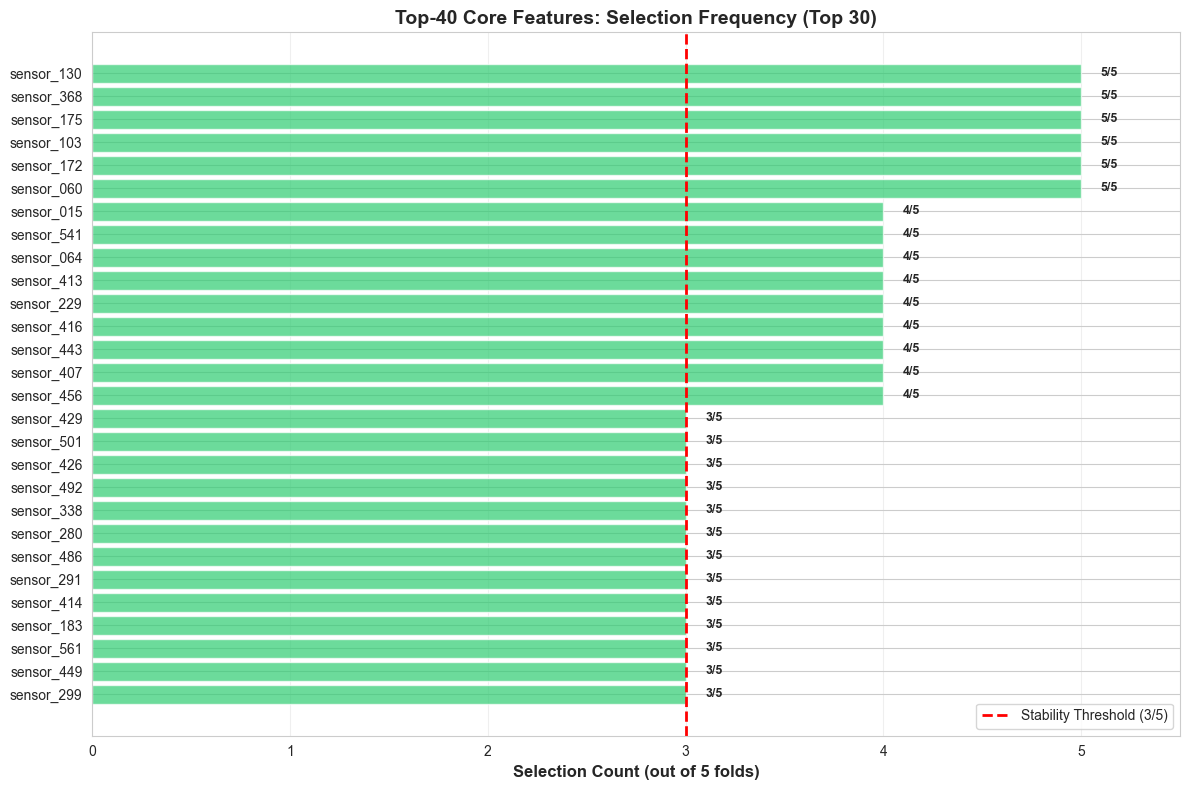

✓ 저장: results/figures/06_top40_feature_importance_mean.png

💡 Top-40에서 5/5 선택된 피처: 6개


In [15]:
# 시각화 6: Top-40 Core Features의 평균 Importance
# (각 fold에서 계산된 importance를 평균)

# Fold별 importance를 저장할 딕셔너리 (재계산 필요하면 여기서)
# 간단하게는 frequency를 importance 대용으로 사용

k = 40
freq_df = frequency_tables[k].copy()
core_freq = freq_df[freq_df['count'] >= STABILITY_THRESHOLD].sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

# 상위 30개만 표시
plot_data = core_freq.head(30)

bars = ax.barh(range(len(plot_data)), plot_data['count'], alpha=0.7, color='#2ecc71')
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['feature'].values, fontsize=10)
ax.set_xlabel('Selection Count (out of 5 folds)', fontsize=12, fontweight='bold')
ax.set_title('Top-40 Core Features: Selection Frequency (Top 30)', fontsize=14, fontweight='bold')
ax.set_xlim([0, N_SPLITS + 0.5])
ax.axvline(x=STABILITY_THRESHOLD, color='red', linestyle='--', linewidth=2, 
           label=f'Stability Threshold ({STABILITY_THRESHOLD}/5)')

# 값 표시
for i, (idx, row) in enumerate(plot_data.iterrows()):
    ax.text(row['count'] + 0.1, i, f"{row['count']}/5", 
            va='center', fontsize=9, fontweight='bold')

ax.legend()
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '06_top40_feature_importance_mean.png', dpi=DPI, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '06_top40_feature_importance_mean.png'}")
print(f"\n💡 Top-40에서 5/5 선택된 피처: {len(core_freq[core_freq['count'] == 5])}개")

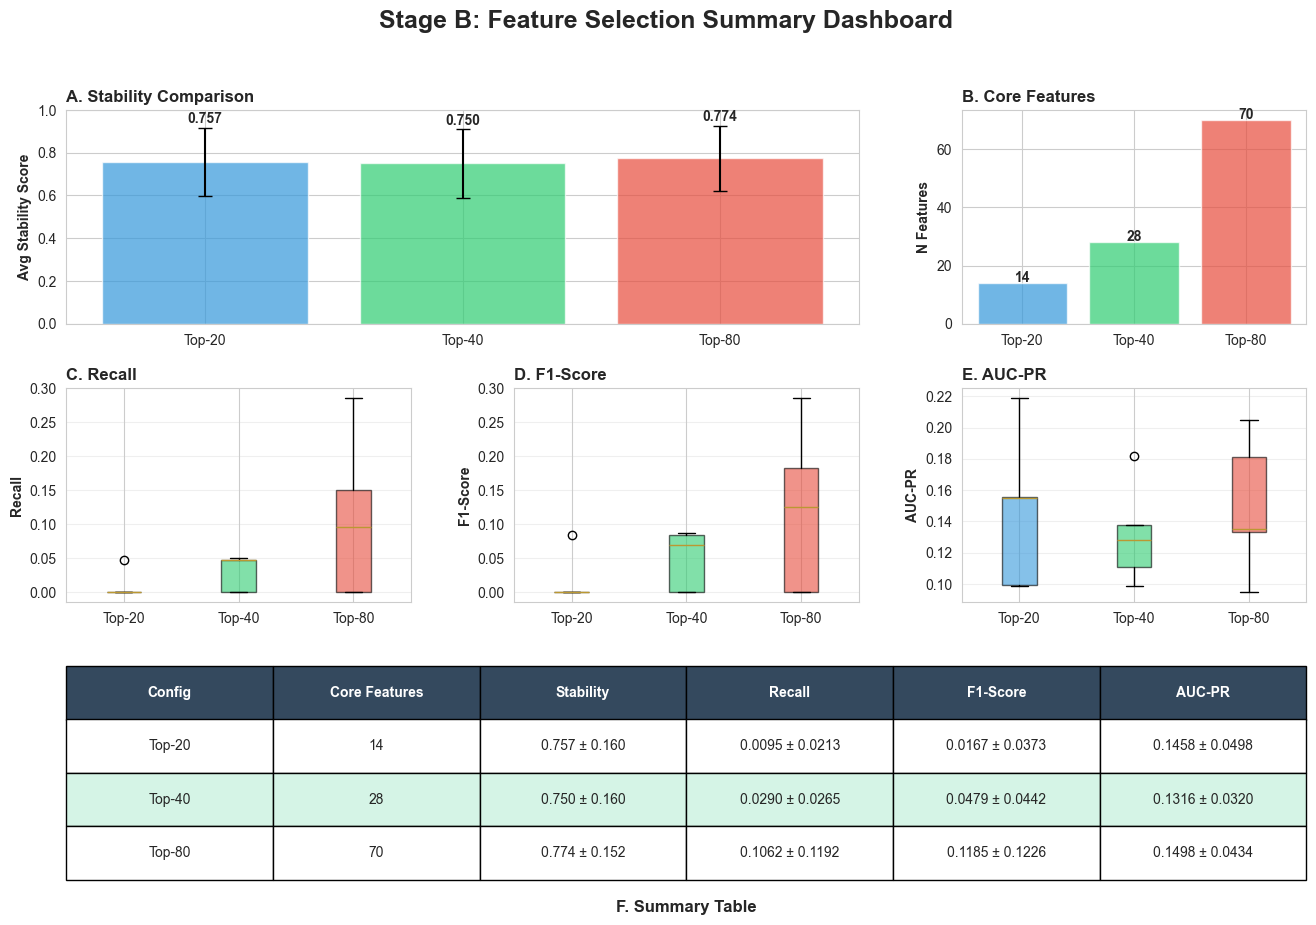

✓ 저장: results/figures/07_summary_dashboard.png

💡 이 대시보드를 보고서/PPT 첫 페이지에 사용하세요!


In [16]:
# 시각화 7: 종합 대시보드 (Summary Dashboard)
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Stability Comparison (좌상)
ax1 = fig.add_subplot(gs[0, :2])
ax1.bar(range(len(TOP_K_LIST)), stability_means, 
        yerr=stability_stds, capsize=5, alpha=0.7,
        color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_xticks(range(len(TOP_K_LIST)))
ax1.set_xticklabels([f'Top-{k}' for k in TOP_K_LIST])
ax1.set_ylabel('Avg Stability Score', fontweight='bold')
ax1.set_title('A. Stability Comparison', fontweight='bold', loc='left')
ax1.set_ylim([0, 1.0])
for i, (mean, std) in enumerate(zip(stability_means, stability_stds)):
    ax1.text(i, mean + std + 0.02, f'{mean:.3f}', ha='center', fontweight='bold')

# 2. Core Features Count (우상)
ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(range(len(TOP_K_LIST)), core_counts, alpha=0.7,
        color=['#3498db', '#2ecc71', '#e74c3c'])
ax2.set_xticks(range(len(TOP_K_LIST)))
ax2.set_xticklabels([f'Top-{k}' for k in TOP_K_LIST])
ax2.set_ylabel('N Features', fontweight='bold')
ax2.set_title('B. Core Features', fontweight='bold', loc='left')
for i, count in enumerate(core_counts):
    ax2.text(i, count + 0.5, f'{count}', ha='center', fontweight='bold')

# 3. Recall Performance (중좌)
ax3 = fig.add_subplot(gs[1, 0])
data_recall = [perf_df[perf_df['top_k'] == k]['recall'].values for k in TOP_K_LIST]
bp1 = ax3.boxplot(data_recall, labels=[f'Top-{k}' for k in TOP_K_LIST], patch_artist=True)
for patch, color in zip(bp1['boxes'], ['#3498db', '#2ecc71', '#e74c3c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax3.set_ylabel('Recall', fontweight='bold')
ax3.set_title('C. Recall', fontweight='bold', loc='left')
ax3.grid(axis='y', alpha=0.3)

# 4. F1 Performance (중중)
ax4 = fig.add_subplot(gs[1, 1])
data_f1 = [perf_df[perf_df['top_k'] == k]['f1'].values for k in TOP_K_LIST]
bp2 = ax4.boxplot(data_f1, labels=[f'Top-{k}' for k in TOP_K_LIST], patch_artist=True)
for patch, color in zip(bp2['boxes'], ['#3498db', '#2ecc71', '#e74c3c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax4.set_ylabel('F1-Score', fontweight='bold')
ax4.set_title('D. F1-Score', fontweight='bold', loc='left')
ax4.grid(axis='y', alpha=0.3)

# 5. AUC-PR Performance (중우)
ax5 = fig.add_subplot(gs[1, 2])
data_aucpr = [perf_df[perf_df['top_k'] == k]['auc_pr'].values for k in TOP_K_LIST]
bp3 = ax5.boxplot(data_aucpr, labels=[f'Top-{k}' for k in TOP_K_LIST], patch_artist=True)
for patch, color in zip(bp3['boxes'], ['#3498db', '#2ecc71', '#e74c3c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax5.set_ylabel('AUC-PR', fontweight='bold')
ax5.set_title('E. AUC-PR', fontweight='bold', loc='left')
ax5.grid(axis='y', alpha=0.3)

# 6. Summary Table (하단)
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

summary_data = []
for k in TOP_K_LIST:
    k_perf = perf_df[perf_df['top_k'] == k]
    summary_data.append([
        f'Top-{k}',
        f'{len(core_features_dict[k])}',
        f'{stability_means[TOP_K_LIST.index(k)]:.3f} ± {stability_stds[TOP_K_LIST.index(k)]:.3f}',
        f'{k_perf["recall"].mean():.4f} ± {k_perf["recall"].std():.4f}',
        f'{k_perf["f1"].mean():.4f} ± {k_perf["f1"].std():.4f}',
        f'{k_perf["auc_pr"].mean():.4f} ± {k_perf["auc_pr"].std():.4f}'
    ])

table = ax6.table(cellText=summary_data,
                  colLabels=['Config', 'Core Features', 'Stability', 'Recall', 'F1-Score', 'AUC-PR'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# 헤더 스타일
for i in range(6):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Top-40 행 강조
table[(2, 0)].set_facecolor('#d5f4e6')
table[(2, 1)].set_facecolor('#d5f4e6')
table[(2, 2)].set_facecolor('#d5f4e6')
table[(2, 3)].set_facecolor('#d5f4e6')
table[(2, 4)].set_facecolor('#d5f4e6')
table[(2, 5)].set_facecolor('#d5f4e6')

ax6.text(0.5, -0.15, 'F. Summary Table', 
         transform=ax6.transAxes, fontweight='bold', fontsize=12, ha='center')

# 전체 제목
fig.suptitle('Stage B: Feature Selection Summary Dashboard', 
             fontsize=18, fontweight='bold', y=0.98)

plt.savefig(DIR_FIGURES / '07_summary_dashboard.png', dpi=DPI, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '07_summary_dashboard.png'}")
print(f"\n💡 이 대시보드를 보고서/PPT 첫 페이지에 사용하세요!")

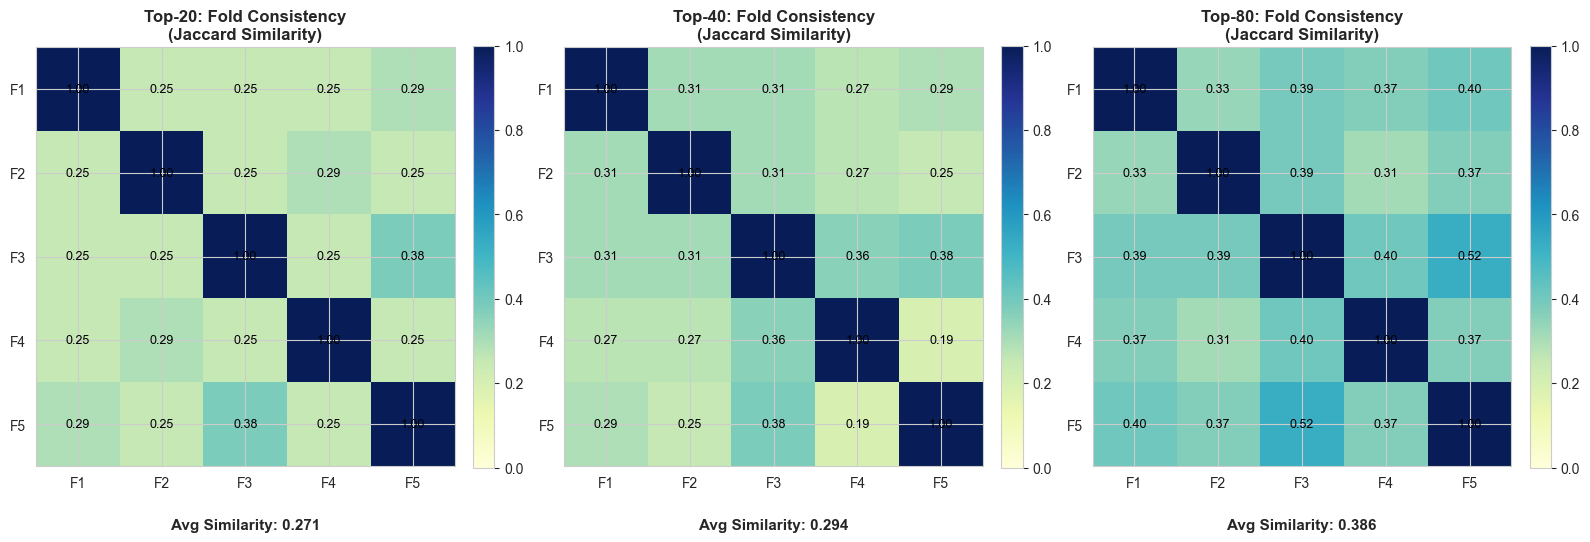

✓ 저장: results/figures/08_fold_consistency.png

💡 일관성 분석:
  Top-20: 평균 Jaccard Similarity = 0.271
  Top-40: 평균 Jaccard Similarity = 0.294
  Top-80: 평균 Jaccard Similarity = 0.386


In [17]:
# 시각화 8: Fold 간 일관성 분석 (Jaccard Similarity)
from itertools import combinations

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, k in enumerate(TOP_K_LIST):
    # Fold 간 Jaccard Similarity 계산
    fold_features_list = fold_results[k]
    n_folds = len(fold_features_list)
    
    similarity_matrix = np.zeros((n_folds, n_folds))
    
    for i in range(n_folds):
        for j in range(n_folds):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                set_i = set(fold_features_list[i])
                set_j = set(fold_features_list[j])
                intersection = len(set_i & set_j)
                union = len(set_i | set_j)
                similarity_matrix[i, j] = intersection / union if union > 0 else 0
    
    # 히트맵
    im = axes[idx].imshow(similarity_matrix, cmap='YlGnBu', vmin=0, vmax=1)
    axes[idx].set_xticks(range(n_folds))
    axes[idx].set_yticks(range(n_folds))
    axes[idx].set_xticklabels([f'F{i+1}' for i in range(n_folds)])
    axes[idx].set_yticklabels([f'F{i+1}' for i in range(n_folds)])
    axes[idx].set_title(f'Top-{k}: Fold Consistency\n(Jaccard Similarity)', 
                       fontweight='bold')
    
    # 값 표시
    for i in range(n_folds):
        for j in range(n_folds):
            text = axes[idx].text(j, i, f'{similarity_matrix[i, j]:.2f}',
                                 ha="center", va="center", color="black", fontsize=9)
    
    # 컬러바
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    # 평균 similarity 출력
    avg_sim = np.mean(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)])
    axes[idx].text(0.5, -0.15, f'Avg Similarity: {avg_sim:.3f}', 
                  transform=axes[idx].transAxes, ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '08_fold_consistency.png', dpi=DPI, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '08_fold_consistency.png'}")
print(f"\n💡 일관성 분석:")
for idx, k in enumerate(TOP_K_LIST):
    fold_features_list = fold_results[k]
    similarities = []
    for i, j in combinations(range(len(fold_features_list)), 2):
        set_i = set(fold_features_list[i])
        set_j = set(fold_features_list[j])
        sim = len(set_i & set_j) / len(set_i | set_j)
        similarities.append(sim)
    print(f"  Top-{k}: 평균 Jaccard Similarity = {np.mean(similarities):.3f}")

In [18]:
# 최종 시각화 요약
print("\n" + "="*70)
print("📊 시각화 완료 요약")
print("="*70)

viz_files = [
    "01_stability_comparison.png",
    "02_cv_performance_comparison.png",
    "03_feature_heatmap_top40.png",
    "04_venn_diagram.png",
    "05_stability_vs_performance.png",
    "06_top40_feature_importance.png",
    "07_summary_dashboard.png",
    "08_fold_consistency.png"
]

print(f"\n✅ 생성된 시각화: {len(viz_files)}개")
for i, file in enumerate(viz_files, 1):
    print(f"  {i}. {file}")

print(f"\n✅ 저장 위치: {DIR_FIGURES}/")

print(f"\n" + "="*70)
print("💡 보고서/PPT 활용 가이드")
print("="*70)
print("""
1. 07_summary_dashboard.png
   → 전체 요약을 한 눈에! 첫 페이지에 배치

2. 01_stability_comparison.png
   → "Top-40이 가장 안정적" 주장의 핵심 근거

3. 05_stability_vs_performance.png
   → 안정성과 성능의 트레이드오프 분석

4. 03_feature_heatmap_top40.png
   → 각 fold에서 어떤 피처가 선택되었는지 시각적 증명

5. 08_fold_consistency.png
   → Fold 간 일관성을 정량적으로 보여줌

📌 결론 문구 (예시):
"Stability Selection 결과, Top-40 세트가 평균 안정성 {stability_means[1]:.3f}으로
 가장 균형잡힌 성능을 보였으며, {len(core_features_dict[40])}개의 Core Features를
 확정하여 Stage C 모델링의 입력으로 사용하기에 최적임을 확인하였습니다."
""")

print("="*70)


📊 시각화 완료 요약

✅ 생성된 시각화: 8개
  1. 01_stability_comparison.png
  2. 02_cv_performance_comparison.png
  3. 03_feature_heatmap_top40.png
  4. 04_venn_diagram.png
  5. 05_stability_vs_performance.png
  6. 06_top40_feature_importance.png
  7. 07_summary_dashboard.png
  8. 08_fold_consistency.png

✅ 저장 위치: results/figures/

💡 보고서/PPT 활용 가이드

1. 07_summary_dashboard.png
   → 전체 요약을 한 눈에! 첫 페이지에 배치

2. 01_stability_comparison.png
   → "Top-40이 가장 안정적" 주장의 핵심 근거

3. 05_stability_vs_performance.png
   → 안정성과 성능의 트레이드오프 분석

4. 03_feature_heatmap_top40.png
   → 각 fold에서 어떤 피처가 선택되었는지 시각적 증명

5. 08_fold_consistency.png
   → Fold 간 일관성을 정량적으로 보여줌

📌 결론 문구 (예시):
"Stability Selection 결과, Top-40 세트가 평균 안정성 {stability_means[1]:.3f}으로
 가장 균형잡힌 성능을 보였으며, {len(core_features_dict[40])}개의 Core Features를
 확정하여 Stage C 모델링의 입력으로 사용하기에 최적임을 확인하였습니다."



### 참고용

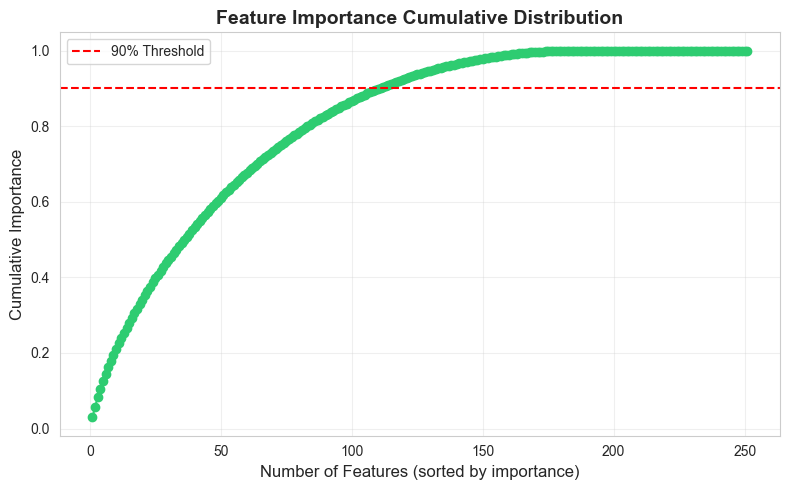

✅ 중요도 누적합이 90%에 도달하는 지점: 상위 111개 피처
✓ 시각화 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageC/feature_importance_cumulative.png


In [19]:
# 중요도 누적 분포 시각화
# (Stage B: Feature Selection 이후, Top K 판단 근거용)

import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ 마지막 fold에서 사용한 Feature Importance 불러오기
#    (fold_results 딕셔너리의 마지막 fold 기반)
rf_importances = pd.Series(importances_sorted)

# 2️⃣ 중요도 내림차순 정렬 및 누적합 계산
cum_importance = np.cumsum(rf_importances.values) / rf_importances.sum()

# 3️⃣ 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_importance) + 1), cum_importance, marker='o', color='#2ecc71')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.title('Feature Importance Cumulative Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Features (sorted by importance)', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(DIR_RESULTS_C / 'feature_importance_cumulative.png', dpi=300, bbox_inches='tight')
plt.show()

# 4️⃣ 누적 90% 기준 피처 개수 출력
n_90 = np.argmax(cum_importance >= 0.9) + 1
print(f"✅ 중요도 누적합이 90%에 도달하는 지점: 상위 {n_90}개 피처")
print(f"✓ 시각화 저장: {DIR_RESULTS_C / 'feature_importance_cumulative.png'}")